# Deep Ensemble

## Theoretic Foundation

Deep Ensembles are proposed as an alternative to Baysian Neural Networks in [Simple and Scalable Predictive Uncertainty
Estimation using Deep Ensembles](https://proceedings.neurips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf). Through combining the outputs of multiple networks predictive uncertainty and a mean prediction can be obtained. 

The Network output is modelled by $f_{\theta}(x) = (\mu_{\theta}(x), \sigma_{\theta}(x))$ where the network is parameterized by weights $\theta$. Then, the mean and variance are interpreted as parameters of a Gaussian 

$p_{\theta}(y|x)=\frac{1}{\sqrt{2\pi\sigma_{\theta}(x)^2}}\exp\big(\frac{(y-\mu_{\theta}(x))^2}{2\sigma_{\theta}(x)^2}\big).$

The loss objective, the loss for batch size $m=1$, is chosen to be the negative log-likelihood of a Gaussian,

$-\log(p_{\theta}(y|x))=\frac{(y-\mu_{\theta}(x))^2}{2\sigma_{\theta}(x)^2}+\frac{\log(\sigma_{\theta}(x)^2)}{2}+\text{const.}$

This means that the likelihood of predicting $y$ given an input $x$ is maximized. Note that when SGD is used the constant can be omitted as the parameters are updated by the learning rate times the gradient of the loss. Hence, the constant vanishes. 

In order to combine the outputs of multiple networks, $M$ networks are trained. As we modelled the output of one network as a Gaussian, now the outputs of $M$ networks are modelled as a Gaussian mixture,

$p_{\theta}(y|x) = M^{-1} \sum_{i=1}^M \mathcal{N}(\mu_{\theta_i}(x), \sigma_{\theta_i}(x)^2).$

Then, the mean of the deep ensemble can be computed as,

$\mu^*(x) = M^{-1} \sum_{i=1}^M \mu_{\theta_i}(x),$

and the variance as,

$\sigma^*(x)^2 = M^{-1} \sum_{i=1}^M \mu_{\theta_i}(x)^2 - \mu^*(x)^2+ M^{-1} \sum_{i=1}^M \sigma_{\theta_i}(x)^2.$

The epistemic uncertainty is given by the variance of the model predictions,

$\sigma^*_{\textit{m}}(x)^2 = M^{-1} \sum_{i=1}^M \mu_{\theta_i}(x)^2 - \mu^*(x)^2.$

The aleatoric uncertainty is given by the mean of the variances predictions,

$\sigma^*_{\textit{d}}(x)^2 = M^{-1} \sum_{i=1}^M \sigma_{\theta_i}(x)^2.$

## Imports

In [1]:
import os
import sys

# required to make the path visible to import the tools
# this will change in public notebooks to be "pip install uq-regression-box"
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
nb_dir

import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from uq_method_box.datamodules import ToyHeteroscedasticDatamodule
from uq_method_box.models import MLP
from lightning_uq_box.uq_methods import DeepEnsembleModel, DeterministicGaussianModel
from uq_method_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions,
    plot_toy_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

In [2]:
seed_everything(0)  # seed everything for reproducibility

Global seed set to 0


0

We define a temporary directory to look at some training metrics and results.

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [3]:
my_temp_dir = tempfile.mkdtemp()

In [4]:
dm = ToyHeteroscedasticDatamodule()

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

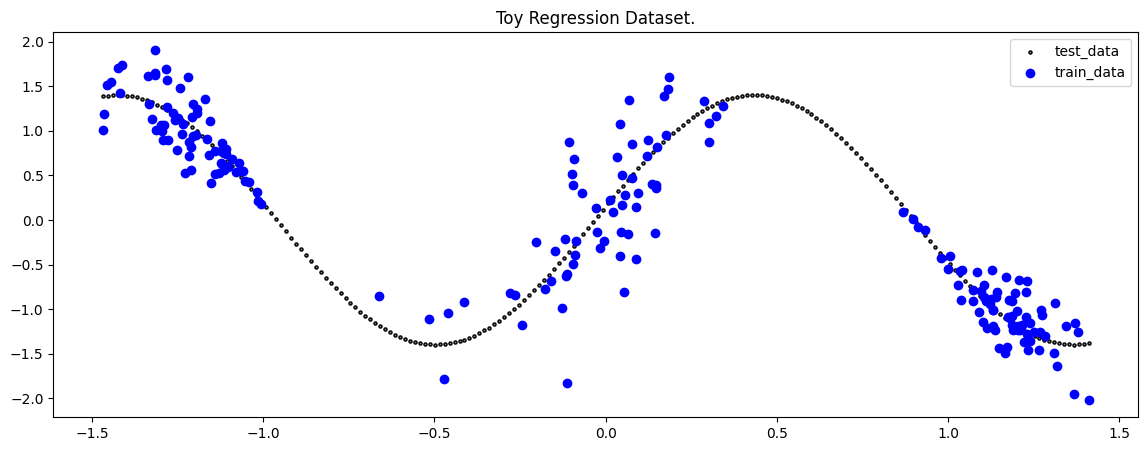

In [6]:
plot_toy_data(X_train, y_train, X_test, y_test)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://torchgeo.readthedocs.io/en/stable/api/models.html#MLP). In the case of the Deep Ensemble, we will train 5 differently initialzed base deterministic networks and later combine them into an ensemble for predictions. We will keep track of the model checkpoints of these models and save them manually in our temporary directory. Later we can use these to initialized the different members that make up our Ensemble during prediction, where only the corresponding ensemble member that is needed will be loaded to reduce memory requirements.

In [7]:
n_ensembles = 5
trained_models_nll = []
for i in range(n_ensembles):
    mlp_model = MLP(n_hidden=[50, 50], n_outputs=2, activation_fn=nn.Tanh())
    ensemble_member = DeterministicGaussianModel(
        mlp_model,
        optimizer=partial(torch.optim.Adam, lr=1e-2),
        burnin_epochs=50,
        max_epochs=350,
        save_dir=None,
    )
    trainer = Trainer(
        max_epochs=300,
        limit_val_batches=0,
        num_sanity_val_steps=0,
        logger=False,
        enable_checkpointing=False,
    )
    trainer.fit(ensemble_member, dm)
    save_path = os.path.join(my_temp_dir, f"model_nll_{i}.ckpt")
    trainer.save_checkpoint(save_path)
    trained_models_nll.append({"base_model": ensemble_member, "ckpt_path": save_path})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 2.8 K 
4 | loss_fn       | NLL              | 0     
---------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 2.8 K 
4 | loss_fn       | NLL              | 0     
---------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 2.8 K 
4 | loss_fn       | NLL              | 0     
---------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 2.8 K 
4 | loss_fn       | NLL              | 0     
---------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 2.8 K 
4 | loss_fn       | NLL              | 0     
---------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


## Construct Deep Ensemble 

In [9]:
deep_ens_nll = DeepEnsembleModel(n_ensembles, trained_models_nll, None)

## Prediction

In [11]:
preds = deep_ens_nll.predict_step(X_test)

## Evaluate Predictions

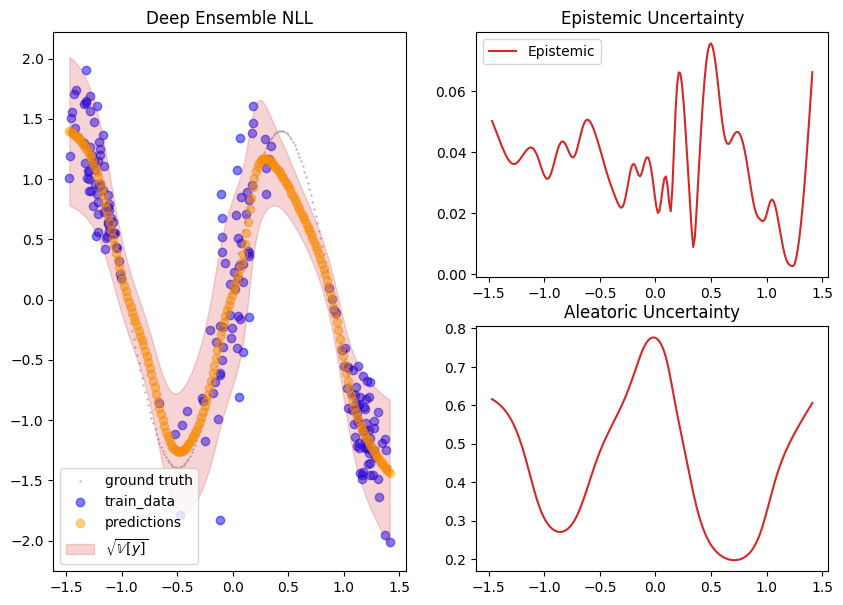

In [14]:
fig = plot_predictions(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["mean"],
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    aleatoric=preds["aleatoric_uct"],
    title="Deep Ensemble NLL",
    show_bands=False,
)

For some additional metrics relevant to UQ, we can use the great [uncertainty-toolbox](https://uncertainty-toolbox.github.io/) that gives us some insight into the calibration of our prediction. For a discussion of why this is important, see ...

<Figure size 1400x500 with 0 Axes>

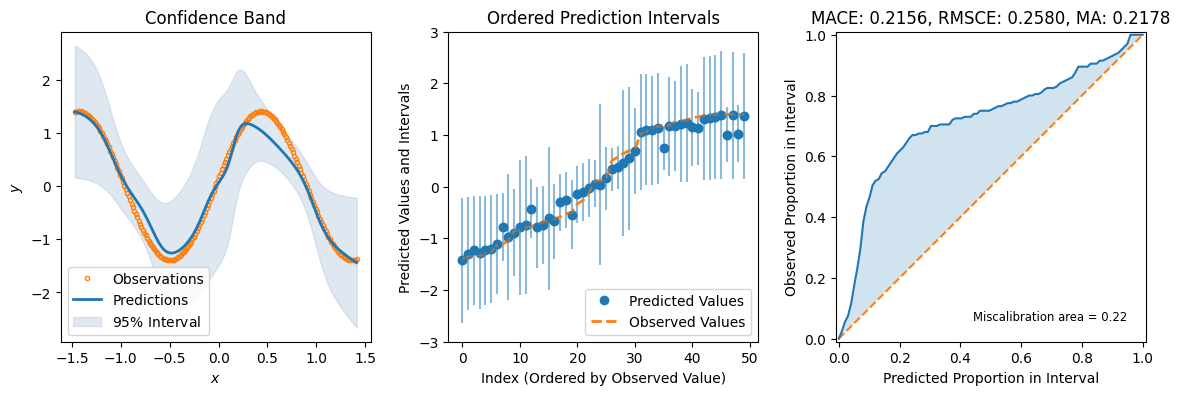

In [15]:
fig = plot_calibration_uq_toolbox(
    preds["mean"], preds["pred_uct"], y_test.cpu().numpy(), X_test.cpu().numpy()
)

## Additional Resources

Links to othere related literature that might be interesting.